Rosenbrock synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/rosen.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rosenbrock'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'RegretMinimized'
util_stp = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_9 = 9


In [8]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
        

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP ERM: StdDev. y \t GP ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t      STP ERM: StdDev. y \t STP ERM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### APPROXIMATE GP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP ERM: StdDev. y 	 GP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1  	 [ 1.43961608 -0.01502976]	 435.96899415933177	 132.4681822844375	 1.2723564639419545	 1.0795775850405465


In [13]:
### APPROXIMATE STP ERM GRADIENTS: 20 random-multi starts (i.e. 20 rms)

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP ERM: StdDev. y 	 STP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1	 [0.80127184 0.1505309 ]	 24.197274053677848	 24.197274053677848	 65.52832569028911	 0.9057416036432936


In [14]:
gp_9_90rms = pd.Series(np.round(gp_9.f_best, 2)).value_counts(sort=True)
gp_9_90rms_df = pd.DataFrame({'Frequency':gp_9_90rms.values,'GP ERM':gp_9_90rms.index})
gp_9_90rms_df


,Frequency,GP ERM
0,13,-0.00
1,7,-2.67


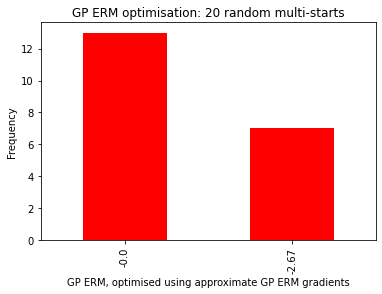

In [15]:
ax = gp_9_90rms.plot.bar(title="GP ERM optimisation: 20 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [16]:
stp_9_90rms = pd.Series(np.round(stp_9.f_best, 2)).value_counts(sort=True)
stp_9_90rms_df = pd.DataFrame({'Frequency':stp_9_90rms.values,'STP ERM (nu=3)':stp_9_90rms.index})
stp_9_90rms_df


,Frequency,STP ERM (nu=3)
0,17,-438.76
1,2,-391.46
2,1,-140.21


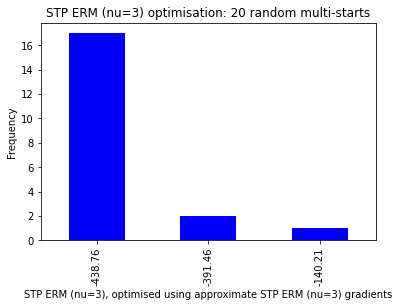

In [17]:
ax = stp_9_90rms.plot.bar(title="STP ERM (nu=3) optimisation: 20 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [18]:
n_start = 50


In [19]:
### APPROXIMATE GP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_gp_9_50rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9_50rms = GPGO_multi(surrogate_gp_9_50rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP ERM: StdDev. y 	 GP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1  	 [ 1.43961606 -0.01502979]	 435.9689864663026	 132.4681822844375	 1.197742234682718	 1.060260453702986


In [20]:
### APPROXIMATE STP ERM GRADIENTS: 50 random-multi starts (i.e. 50 rms)

np.random.seed(run_num_9)
surrogate_stp_9_50rms = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9_50rms = GPGO_multi_STP(surrogate_stp_9_50rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_9_50rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP ERM: StdDev. y 	 STP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1	 [0.80127189 0.15053085]	 24.19728751243553	 24.19728751243553	 71.10692045609912	 0.889381790593329


In [21]:
gp_9_50rms = pd.Series(np.round(gp_9_50rms.f_best, 2)).value_counts(sort=True)
gp_9_50rms_df = pd.DataFrame({'Frequency':gp_9_50rms.values,'GP ERM':gp_9_50rms.index})
gp_9_50rms_df


,Frequency,GP ERM
0,36,-0.00
1,14,-2.67


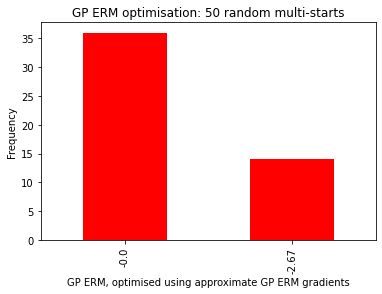

In [22]:
ax = gp_9_50rms.plot.bar(title="GP ERM optimisation: 50 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [23]:
stp_9_50rms = pd.Series(np.round(stp_9_50rms.f_best, 2)).value_counts(sort=True)
stp_9_50rms_df = pd.DataFrame({'Frequency':stp_9_50rms.values,'STP ERM (nu=3)':stp_9_50rms.index})
stp_9_50rms_df


,Frequency,STP ERM (nu=3)
0,43,-438.76
1,4,-391.46
2,3,-140.21


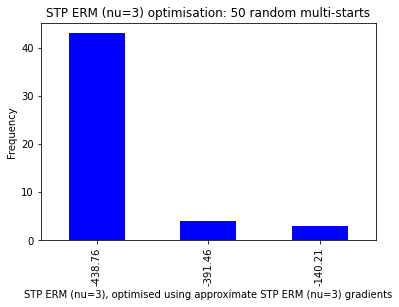

In [24]:
ax = stp_9_50rms.plot.bar(title="STP ERM (nu=3) optimisation: 50 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [25]:
n_start = 100


In [26]:
### APPROXIMATE GP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_gp_9_100rms = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9_100rms = GPGO_multi(surrogate_gp_9_100rms, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP ERM: StdDev. y 	 GP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1  	 [ 1.43961606 -0.01502979]	 435.9689864663026	 132.4681822844375	 1.2543319113174098	 1.0568468093922274


In [27]:
### APPROXIMATE STP ERM GRADIENTS: 100 random-multi starts (i.e. 100 rms)

np.random.seed(run_num_9)
surrogate_stp_9_100rms = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9_100rms = GPGO_multi_STP(surrogate_stp_9_100rms, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
stp_9_100rms.run(max_iter = 1, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP ERM: StdDev. y 	 STP ERM: StdDev. x 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    	    
1	 [0.80127192 0.15053087]	 24.197289344889793	 24.197289344889793	 71.09234405309464	 0.8658126623104179


In [28]:
gp_9_100rms = pd.Series(np.round(gp_9_100rms.f_best, 2)).value_counts(sort=True)
gp_9_100rms_df = pd.DataFrame({'Frequency':gp_9_100rms.values,'GP ERM':gp_9_100rms.index})
gp_9_100rms_df


,Frequency,GP ERM
0,67,-0.00
1,33,-2.67


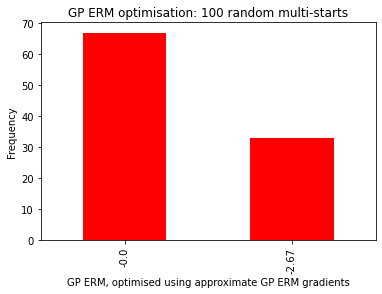

In [29]:
ax = gp_9_100rms.plot.bar(title="GP ERM optimisation: 100 random multi-starts", xlabel="GP ERM, optimised using approximate GP ERM gradients", ylabel="Frequency", color="red")


In [30]:
stp_9_100rms = pd.Series(np.round(stp_9_100rms.f_best, 2)).value_counts(sort=True)
stp_9_100rms_df = pd.DataFrame({'Frequency':stp_9_100rms.values,'STP ERM (nu=3)':stp_9_100rms.index})
stp_9_100rms_df


,Frequency,STP ERM (nu=3)
0,87,-438.76
1,7,-391.46
2,6,-140.21


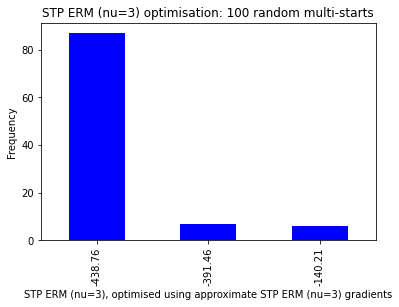

In [31]:
ax = stp_9_100rms.plot.bar(title="STP ERM (nu=3) optimisation: 100 random multi-starts", xlabel="STP ERM (nu=3), optimised using approximate STP ERM (nu=3) gradients", ylabel="Frequency", color="blue")


In [32]:
print(gp_9_90rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.00 &  13 \\
-2.67 &   7 \\
\bottomrule
\end{tabular}



In [33]:
print(stp_9_90rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-438.76 &  17 \\
-391.46 &   2 \\
-140.21 &   1 \\
\bottomrule
\end{tabular}



In [34]:
print(gp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.00 &  36 \\
-2.67 &  14 \\
\bottomrule
\end{tabular}



In [35]:
print(stp_9_50rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-438.76 &  43 \\
-391.46 &   4 \\
-140.21 &   3 \\
\bottomrule
\end{tabular}



In [36]:
print(gp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-0.00 &  67 \\
-2.67 &  33 \\
\bottomrule
\end{tabular}



In [37]:
print(stp_9_100rms.to_latex(index=True))


\begin{tabular}{lr}
\toprule
{} &   0 \\
\midrule
-438.76 &  87 \\
-391.46 &   7 \\
-140.21 &   6 \\
\bottomrule
\end{tabular}

